Analysis of the progression of RL deconvolution with different methods

RedLionfish: rlsp.doRLDeconvolution_DL2_4, rlocl.nonBlock_RLDeconvolutionReiknaOCL
skimage: restoration.richardson_lucy

Creates a 3D gauss image (gauss PSF convoluted with dot)

After *n* iterations, fits gaussian to data to collect width.

Plots gaussian width vs iteration, error and time vs iteration

Check SageMath analysis [gauss_progress.ipynb](./gauss_progress.ipynb) for more theoretical analysis and formulas on the behaviour of gaussian curves after RL filtering

In [26]:
import numpy as np
import tifffile
import os
import napari
import matplotlib.pyplot as plt
import RedLionfishDeconv.helperfunctions as rlh

In [27]:
from scipy.optimize import curve_fit

def gaussian(coords3d, a, sigma):
    #Assume it is centered at zero
    return a*np.exp(-0.5*(coords3d[0]**2 + coords3d[1]**2+ coords3d[2]**2)/ sigma**2 )

def getFitGaussParamsOf3DDataAtCentre(data3d, crop_centre_width=None):
    shape = data3d.shape
    centre = [int(w0/2) for w0 in shape]

    #crop a size of 32x32x32
    #data0 = data3d[ centre[0]-16:centre[0]+16, centre[1]-16:centre[1]+16, centre[2]-16:centre[2]+16]
    #range0=16
    data0=None
    if crop_centre_width is None:
        data0=data3d
        range0=int(data3d.shape[0]/2) #Assumes it is a cube
    else:
        range0 = int(crop_centre_width/2)
        data0 = data3d[ centre[0]-range0:centre[0]+range0, centre[1]-range0:centre[1]+range0, centre[2]-range0:centre[2]+range0]
    xrange=np.arange(-range0,range0)
    yrange = np.array(xrange)
    zrange = np.array(xrange)

    #guess amplitude
    a0=data0.max()
    xx,yy,zz = np.meshgrid(xrange,yrange,zrange)

    xx_flat= xx.flatten()
    yy_flat = yy.flatten()
    zz_flat = zz.flatten()

    #coordsvalues = list(zip(xx_flat, yy_flat, zz_flat))

    coordsvalues = np.array([zz_flat,yy_flat,xx_flat])
    #print(coordsvalues.shape)
    
    data0_flat = data0.flatten()

    popt, pcov = curve_fit(gaussian,coordsvalues, data0_flat, p0=[a0,range0])
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

In [28]:
psf=rlh.generateGaussPSF((32,32,32), sigma=5)
psf_norm = psf/np.sum(psf)

In [29]:
getFitGaussParamsOf3DDataAtCentre(psf)

(array([0.07978845, 4.99999998]), array([4.05186081e-11, 1.31170959e-09]))

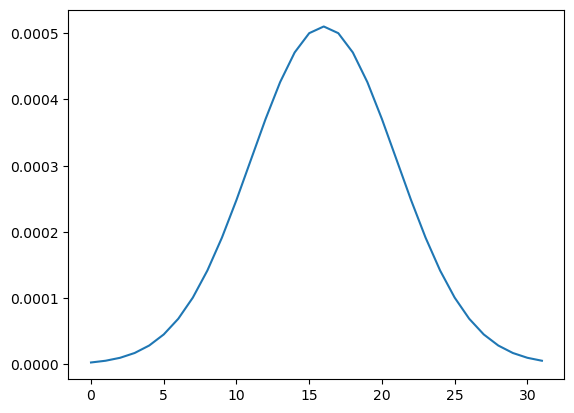

In [30]:
plt.plot(psf_norm[16,16,:])

In [31]:
import napari
napari.view_image(psf_norm)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 15.5, 15.5), zoom=15.853124999999999, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 32.0, 1.0), (0.0, 32.0, 1.0), (0.0, 32.0, 1.0)), current_step=(16, 16, 16), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'psf_norm' at 0x1d0c7d48280>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=False

In [32]:
print(psf_norm.shape)
print(psf_norm.dtype)
print(np.sum(psf_norm))
print(psf_norm.min())
print(psf_norm.max())

(32, 32, 32)
float32
1.0
1.0887157e-10
0.0005101266


In [33]:
import scipy
#Create data array that will be used for deconvolution benchmarking
size = 256
amplitude = 1e6

data0 = np.zeros((size,size,size), dtype=np.float32)

data0[int(size/2),int(size/2),int(size/2)]=amplitude

#Convolute
data_convolved = scipy.signal.convolve(data0, psf_norm, mode='same')

print(f"dataconv max, min: {data_convolved.max()}, {data_convolved.min()}")
#Some values are negative, and they shouldn't
data_convolved_fix = np.where(data_convolved<0, 0, data_convolved)
print(f"data_convolved_fix max, min: {data_convolved_fix.max()}, {data_convolved_fix.min()}")

#Add noise
rng = np.random.default_rng()
data = rng.poisson(lam = data_convolved_fix).astype(np.float32)
print(f"data max, min: {data.max()}, {data.min()}")


dataconv max, min: 510.12646484375, -6.430040957638994e-05
data_convolved_fix max, min: 510.12646484375, 0.0
data max, min: 545.0, 0.0


In [34]:
data.dtype

dtype('float32')

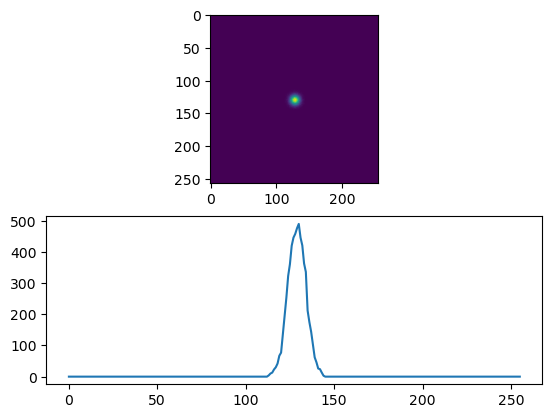

In [35]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(2,1)
ax0.imshow(data[int(size/2),:,:])
ax1.plot(data[int(size/2),int(size/2),:])

In [36]:
import napari
napari.view_image(data)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 127.5, 127.5), zoom=1.9816406249999998, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 256.0, 1.0), (0.0, 256.0, 1.0), (0.0, 256.0, 1.0)), current_step=(128, 128, 128), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'data' at 0x1d08dc75370>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_vertices=F

In [37]:
#Second value is the sigma (~gaussian width)
getFitGaussParamsOf3DDataAtCentre(data, crop_centre_width=32)

(array([481.36853674,   5.09842077]), array([1.08792166, 0.00595355]))

In [39]:
getFitGaussParamsOf3DDataAtCentre(data) #very slow as data is not cropped

(array([481.39188638,   5.09824549]), array([0.04806874, 0.00026289]))

ok, even with noise it gives a stdev close to the sigma value used

In [40]:
#Test
import RedLionfishDeconv.RLDeconv3DScipy as rlsp
func0 = rlsp.doRLDeconvolution_DL2_4
res0 = func0(data,psf_norm, niter=2)

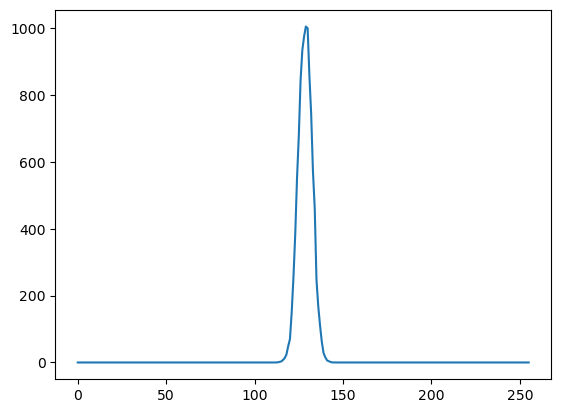

In [41]:
plt.plot(res0[int(size/2),int(size/2),:])

In [42]:
getFitGaussParamsOf3DDataAtCentre(res0, crop_centre_width=32)

(array([1026.86686559,    3.96000661]), array([1.97003296, 0.0039232 ]))

## See the effect of RL deconvolution on the gaussian width

In [43]:
#See the effect of RL deconvolution on the gaussian width
import RedLionfishDeconv.RLDeconv3DReiknaOCL as rlocl
import RedLionfishDeconv.RLDeconv3DScipy as rlsp
import skimage.restoration as rlsk
import time

def rl_scikit_wrapper(data, psf, niter):
    return rlsk.richardson_lucy(data,psf, num_iter=niter, clip=False, filter_epsilon=1e-16)

rlfuncs = [rlsp.doRLDeconvolution_DL2_4, rlocl.nonBlock_RLDeconvolutionReiknaOCL, rl_scikit_wrapper]

results=[]
for rlfunc0 in rlfuncs:
    print(rlfunc0.__name__)
    res_withthisfunc=[]
    for iter0 in range(1,10):
        starttime = time.perf_counter()
        res0 = rlfunc0(data,psf_norm,niter=iter0)
        endtime = time.perf_counter()
        exectime = endtime-starttime

        #Get gauss width
        g_fit_params, perr = getFitGaussParamsOf3DDataAtCentre(res0,crop_centre_width=32)

        print(f"iter: {iter0}, g_fit_params:{g_fit_params}, perr:{perr}, exectime:{exectime}")

        res_withthisfunc.append( [iter0, g_fit_params, perr, exectime])
    results.append([rlfunc0.__name__ ,res_withthisfunc])

doRLDeconvolution_DL2_4
iter: 1, g_fit_params:[741.79221266   4.38740663], perr:[1.44101062 0.00440139], exectime:2.0180449000000067
iter: 2, g_fit_params:[1026.86686559    3.96000661], perr:[1.97003296 0.0039232 ], exectime:3.2547155999999973
iter: 3, g_fit_params:[1304.3696046     3.66657795], perr:[2.61054066 0.00378944], exectime:4.650070900000003
iter: 4, g_fit_params:[1573.39256604    3.44911431], perr:[3.34712787 0.00378903], exectime:6.1388569000000075
iter: 5, g_fit_params:[1833.93507092    3.27965137], perr:[4.16299765e+00 3.84446349e-03], exectime:7.377294100000029
iter: 6, g_fit_params:[2086.3174122     3.14278959], perr:[5.04343524e+00 3.92325491e-03], exectime:9.210124899999983
iter: 7, g_fit_params:[2330.97825276    3.02925155], perr:[5.97635327e+00 4.01068018e-03], exectime:10.646681999999998
iter: 8, g_fit_params:[2568.3879317     2.93307192], perr:[6.95205666e+00 4.09977543e-03], exectime:11.220053300000018
iter: 9, g_fit_params:[2799.00862889    2.85021978], perr:[7.

In [44]:
results

[['doRLDeconvolution_DL2_4',
  [[1,
    array([741.79221266,   4.38740663]),
    array([1.44101062, 0.00440139]),
    2.0180449000000067],
   [2,
    array([1026.86686559,    3.96000661]),
    array([1.97003296, 0.0039232 ]),
    3.2547155999999973],
   [3,
    array([1304.3696046 ,    3.66657795]),
    array([2.61054066, 0.00378944]),
    4.650070900000003],
   [4,
    array([1573.39256604,    3.44911431]),
    array([3.34712787, 0.00378903]),
    6.1388569000000075],
   [5,
    array([1833.93507092,    3.27965137]),
    array([4.16299765e+00, 3.84446349e-03]),
    7.377294100000029],
   [6,
    array([2086.3174122 ,    3.14278959]),
    array([5.04343524e+00, 3.92325491e-03]),
    9.210124899999983],
   [7,
    array([2330.97825276,    3.02925155]),
    array([5.97635327e+00, 4.01068018e-03]),
    10.646681999999998],
   [8,
    array([2568.3879317 ,    2.93307192]),
    array([6.95205666e+00, 4.09977543e-03]),
    11.220053300000018],
   [9,
    array([2799.00862889,    2.85021978])

In [45]:
import pickle
with open('RL_bencm_gauss_progress_ASUS_Avivo_14.pkl', 'wb' ) as file0:
    pickle.dump(results,file0)

plot results

In [46]:
it1=results[0][1]
it1

[[1,
  array([741.79221266,   4.38740663]),
  array([1.44101062, 0.00440139]),
  2.0180449000000067],
 [2,
  array([1026.86686559,    3.96000661]),
  array([1.97003296, 0.0039232 ]),
  3.2547155999999973],
 [3,
  array([1304.3696046 ,    3.66657795]),
  array([2.61054066, 0.00378944]),
  4.650070900000003],
 [4,
  array([1573.39256604,    3.44911431]),
  array([3.34712787, 0.00378903]),
  6.1388569000000075],
 [5,
  array([1833.93507092,    3.27965137]),
  array([4.16299765e+00, 3.84446349e-03]),
  7.377294100000029],
 [6,
  array([2086.3174122 ,    3.14278959]),
  array([5.04343524e+00, 3.92325491e-03]),
  9.210124899999983],
 [7,
  array([2330.97825276,    3.02925155]),
  array([5.97635327e+00, 4.01068018e-03]),
  10.646681999999998],
 [8,
  array([2568.3879317 ,    2.93307192]),
  array([6.95205666e+00, 4.09977543e-03]),
  11.220053300000018],
 [9,
  array([2799.00862889,    2.85021978]),
  array([7.96293298e+00, 4.18719886e-03]),
  12.60794390000001]]

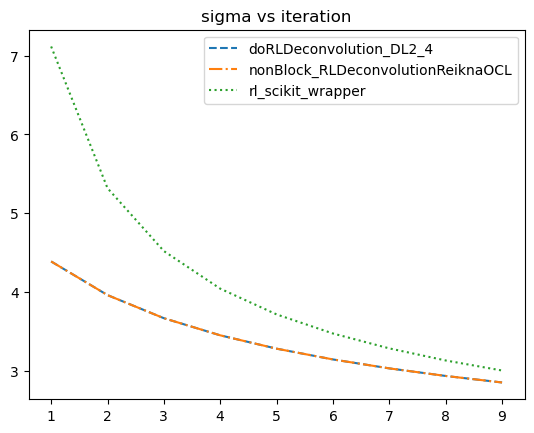

In [47]:
#sigma vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[1][1]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("sigma vs iteration")

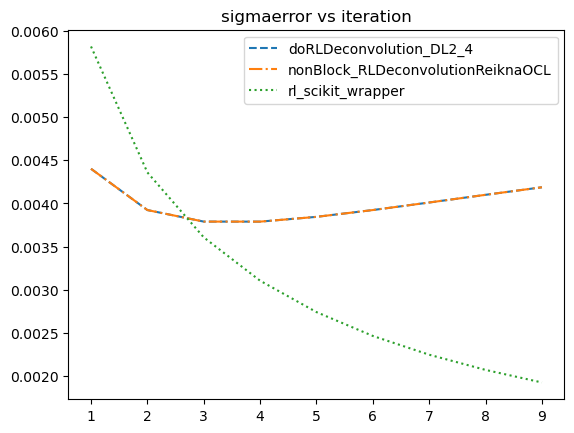

In [48]:
#sigmaerror vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[2][1]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("sigmaerror vs iteration")

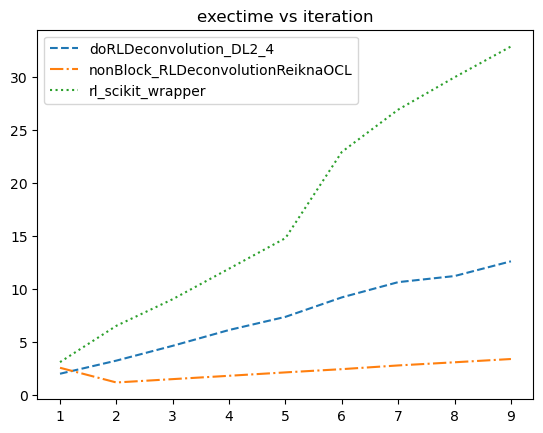

In [49]:
#exectime vs iteration
plt.figure()
lines = ["--","-.",":"]
from itertools import cycle
linecycler = cycle(lines)

for i0,it0 in enumerate(results):
    funcname = it0[0]
    
    xvalues=[]
    yvalues=[]
    for it1 in it0[1]:
        #print(it1)
        iter = it1[0]
        sigma = it1[3]
        
        xvalues.append(iter)
        yvalues.append(sigma)

    plt.plot(xvalues,yvalues, label=funcname, ls=next(linecycler))
    plt.legend()
    plt.title("exectime vs iteration")